### 01/04/2025 
Modifico funzioni come mi dice copilot perchè nel calcolo di H ci soiìno dei loop e dei calcoli ridondanti. 
Ma non so se nella funzione link reliability che mi restituisca valore 1 se 

In [7]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations

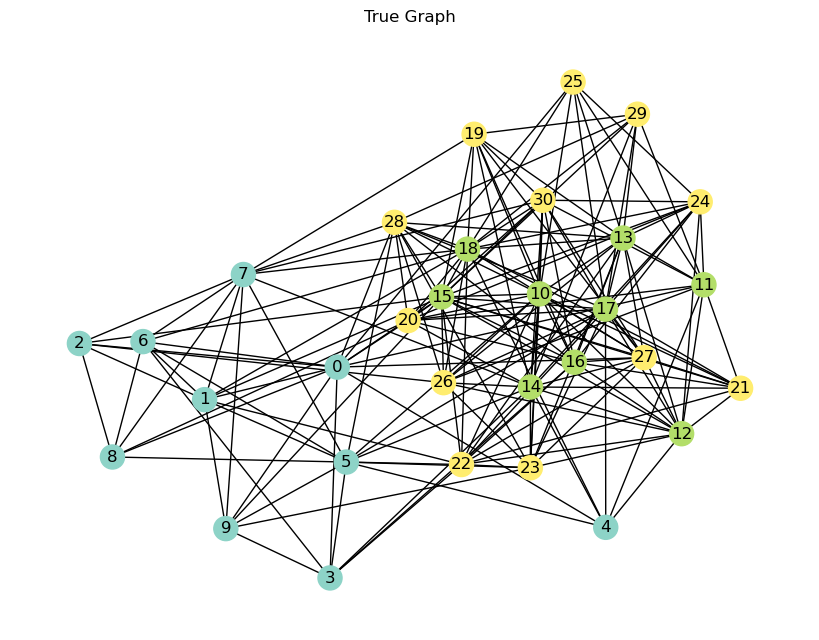

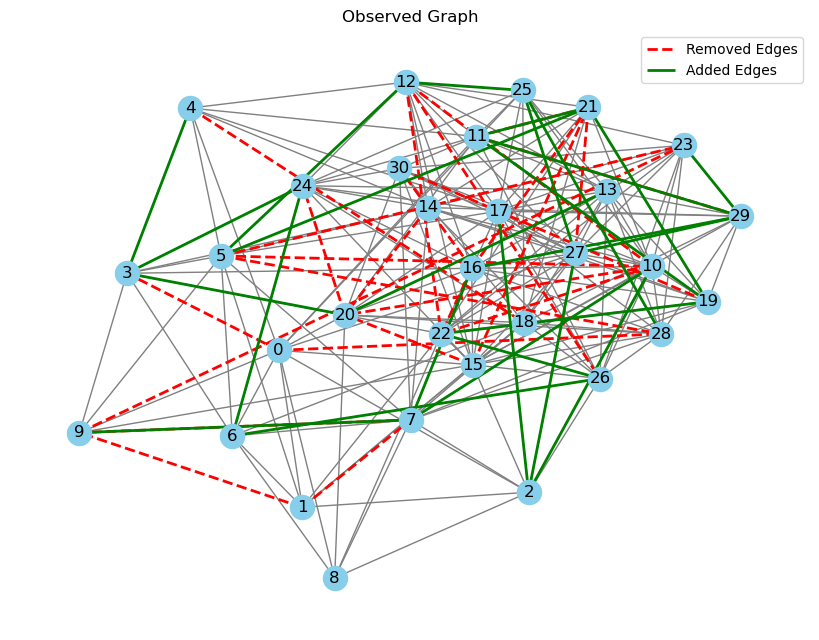

Link Reliability for some node pairs:
Pair (0, 1): RL = 0.8472
Pair (0, 2): RL = 0.8515
Pair (0, 3): RL = 0.3324
Pair (0, 4): RL = 0.5014
Pair (0, 5): RL = 0.3374
Pair (0, 6): RL = 0.8515
Pair (0, 7): RL = 0.3400
Pair (0, 8): RL = 0.8409
Pair (0, 9): RL = 0.8515
Pair (0, 10): RL = 0.3332
Workflow completed successfully.
Probabilità che un falso negativo abbia un RL più alto di un vero negativo: 0.6356
Probabilità che un falso positivo abbia un RL più basso di un vero positivo: 0.7115


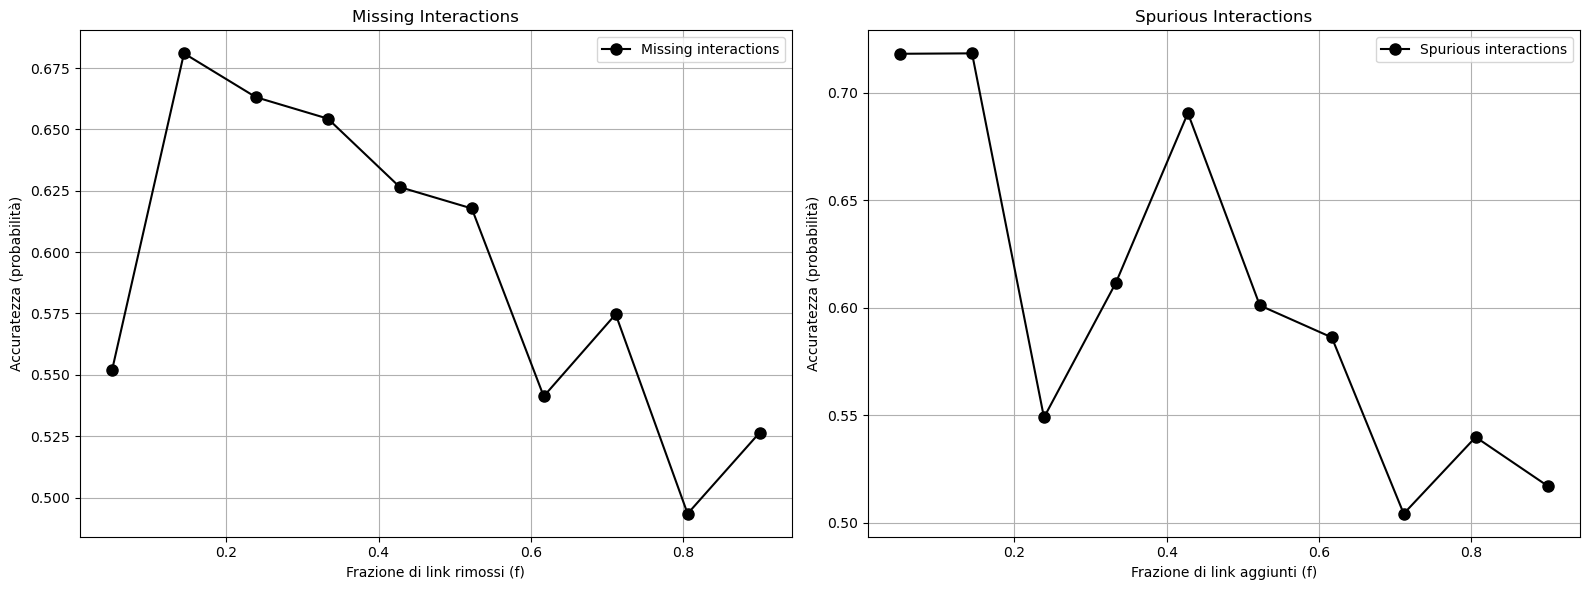

In [8]:
def generate_block_network(block_sizes: list[int], prob_matrix: np.ndarray) -> nx.Graph:
    """
    Generate a stochastic block model (SBM) network.

    :param block_sizes: List specifying the number of nodes in each block.
    :param prob_matrix: NxN matrix with connection probabilities between blocks.
    :return: A NetworkX Graph object.
    """
    num_blocks = len(block_sizes)
    G = nx.Graph()
    
    # Create nodes with block labels
    node_labels = []
    current_label = 0
    for i, size in enumerate(block_sizes):
        for _ in range(size):
            G.add_node(current_label, block=i)
            node_labels.append(current_label)
            current_label += 1
    
    # Add edges based on probabilities
    for i in range(num_blocks):
        for j in range(num_blocks):
            block_i_nodes = range(sum(block_sizes[:i]), sum(block_sizes[:i + 1]))
            block_j_nodes = range(sum(block_sizes[:j]), sum(block_sizes[:j + 1]))
            
            # Generate random adjacency matrix for the block pair
            rand_matrix = np.random.rand(len(block_i_nodes), len(block_j_nodes))
            edges = np.argwhere(rand_matrix < prob_matrix[i][j])
            
            for edge in edges:
                u = block_i_nodes[edge[0]]
                v = block_j_nodes[edge[1]]
                if u < v:  # Avoid duplicate edges
                    G.add_edge(u, v)
    
    return G

def modify_network(G: nx.Graph, modification_fraction: float) -> tuple[nx.Graph, list[tuple[int, int]], list[tuple[int, int]]]:
    """
    Modify the network by randomly removing and adding a fraction of edges.

    :param G: Original graph.
    :param modification_fraction: Fraction of edges to modify.
    :return: Modified graph, list of removed edges, and list of added edges.
    """
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    # Shuffle edges and nodes for random selection
    np.random.shuffle(edges)
    np.random.shuffle(nodes)
    
    removed_edges = edges[:num_to_modify // 2]
    added_edges = []
    
    # Remove edges
    for edge in removed_edges:
        G_modified.remove_edge(*edge)
    
    # Add new edges
    while len(added_edges) < num_to_modify // 2:
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v):
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges

def plot_modified_network(G: nx.Graph, removed_edges: list[tuple[int, int]], added_edges: list[tuple[int, int]], title: str):
    """
    Plot the network with removed and added edges highlighted.

    :param G: Graph to plot.
    :param removed_edges: List of edges removed from the graph.
    :param added_edges: List of edges added to the graph.
    :param title: Title of the plot.
    """
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=2, label='Removed Edges')
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=2, label='Added Edges')
    plt.title(title)
    plt.legend()
    plt.show()

def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: np.random.randint(0, num_nodes) for node in G.nodes()}

def calculate_H(P, G):
    """Calculate H(P) for a given partition P and graph G."""
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}
    r = {}

    # Count observed links and compute possible links
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1

    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])

    # Compute H(P)
    H = 0.0
    for key in r:
        H += math.log1p(r[key])  # log(r[key] + 1)
        links = lO.get(key, 0)
        comb_value = math.comb(r[key], links) if r[key] >= links else 1
        H += math.log1p(comb_value - 1)  # log(comb_value + 1e-10)

    return H

def metropolis_acceptance(delta_H):
    """Decide whether to accept a new state based on Metropolis criterion."""
    return delta_H <= 0 or np.random.rand() < np.exp(-delta_H)

def metropolis_MCMC(G, num_samples=10000, equilibration=500):
    """Perform MCMC sampling to explore the partition space."""
    num_nodes = len(G.nodes())
    P = initialize_partition(G)
    partitions = []

    # Equilibration phase
    for _ in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        new_group = random.choice(range(num_nodes))
        old_H = calculate_H(P, G)
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group

    # Sampling phase
    for _ in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        new_group = random.choice(range(num_nodes))
        old_H = calculate_H(P, G)
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        partitions.append(P.copy())

    return partitions

from collections import defaultdict

def estimate_link_reliability(G, partitions):
    """
    Estimate link reliability RL_ij for each pair (i, j) with i < j.
    """
    nodes = list(G.nodes())
    reliability = defaultdict(float)
    Z = 0.0

    for P in partitions:
        weight = np.exp(-calculate_H(P, G))
        Z += weight

        block_nodes = defaultdict(list)
        for node, group in P.items():
            block_nodes[group].append(node)

        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            lO[(g, g)] = sum(1 for u, v in combinations(block_nodes[g], 2) if G.has_edge(u, v))
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            lO[key] = sum(1 for u in block_nodes[g1] for v in block_nodes[g2] if G.has_edge(u, v))

        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    for key in reliability:
        reliability[key] /= Z

    return dict(reliability)

def run_workflow(block_sizes, prob_matrix, modification_fraction, num_samples, equilibration):
    """
    Run the full workflow: generate graph, modify it, run MCMC, and estimate reliability.
    """
    # Generate the "true" graph
    global G_true, G_obs, RL  # Rendi le variabili globali
    G_true = generate_block_network(block_sizes, prob_matrix)
    pos_true = nx.spring_layout(G_true)
    plt.figure(figsize=(8, 6))
    nx.draw(G_true, pos_true, with_labels=True, 
            node_color=[G_true.nodes[n]['block'] for n in G_true.nodes()], 
            edge_color='black', cmap=plt.cm.Set3)
    plt.title("True Graph")
    plt.show()

    # Modify the graph to create the observed graph
    G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)
    plot_modified_network(G_obs, removed_edges, added_edges, title="Observed Graph")

    # Run MCMC sampling
    partitions = metropolis_MCMC(G_obs, num_samples=num_samples, equilibration=equilibration)

    # Estimate link reliability
    RL = estimate_link_reliability(G_obs, partitions)

    # Print results for the first 10 pairs
    print("Link Reliability for some node pairs:")
    for i, key in enumerate(RL):
        if i >= 10:
            break
        print(f"Pair {key}: RL = {RL[key]:.4f}")

    return G_true, G_obs, RL

def validate_inputs(block_sizes, prob_matrix, modification_fraction):
    if not isinstance(block_sizes, list) or not all(isinstance(x, int) and x > 0 for x in block_sizes):
        raise ValueError("block_sizes must be a list of positive integers.")
    if not isinstance(prob_matrix, list) or not all(isinstance(row, list) for row in prob_matrix):
        raise ValueError("prob_matrix must be a 2D list.")
    if len(prob_matrix) != len(block_sizes) or any(len(row) != len(block_sizes) for row in prob_matrix):
        raise ValueError("prob_matrix dimensions must match the number of blocks in block_sizes.")
    if not (0 <= modification_fraction <= 1):
        raise ValueError("modification_fraction must be between 0 and 1.")
    
def calculate_sampling_params(G):
    """
    Dynamically calculate sampling parameters based on graph size.
    """
    num_nodes = len(G.nodes())
    num_samples = max(1000, num_nodes * 100)  # At least 1000 samples or 100 per node
    equilibration = max(100, num_nodes * 10)  # At least 100 steps or 10 per node
    return num_samples, equilibration

def main():
    # Define parameters
    block_sizes = [10, 9, 12]
    prob_matrix = [[0.6, 0.2, 0.1],
                   [0.2, 0.5, 0.8],
                   [0.1, 0.8, 0.3]]
    modification_fraction = 0.3

    # Validate inputs
    validate_inputs(block_sizes, prob_matrix, modification_fraction)

    # Dynamically calculate sampling parameters
    G_dummy = generate_block_network(block_sizes, prob_matrix)  # Dummy graph for parameter calculation
    num_samples, equilibration = calculate_sampling_params(G_dummy)

    # Run the workflow
    G_true, G_obs, RL = run_workflow(block_sizes, prob_matrix, modification_fraction, 
                                     num_samples=num_samples, equilibration=equilibration)

    # Save or display results as needed
    print("Workflow completed successfully.")

if __name__ == "__main__":
    main()

def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Calcola la probabilità che un falso negativo (AO=0, AT=1) abbia un RL
    maggiore di un vero negativo (AO=0, AT=0).
    
    G_true: grafo true (AT)
    G_obs: grafo osservato (AO)
    RL: dizionario delle link reliability per ogni coppia (i,j) con i<j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Costruiamo le liste delle coppie in base alle definizioni
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # Se non ci sono esempi, ritorna None o 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # Per ogni coppia, sommiamo 1 se il falso negativo ha RL > RL del vero negativo,
    # 0.5 se sono uguali.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability

def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Calcola la probabilità che un falso positivo (AO=1, AT=0) abbia un RL
    inferiore a un vero positivo (AO=1, AT=1).
    
    G_true: grafo true (AT)
    G_obs: grafo osservato (AO)
    RL: dizionario delle link reliability per ogni coppia (i,j) con i<j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Ora vogliamo che il falso positivo abbia RL inferiore rispetto al vero positivo,
    # cioè, in un ordinamento decrescente il vero positivo deve venire prima.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability

# Esegui il workflow e cattura i risultati
#G_true, G_obs, RL = run_workflow(block_sizes, prob_matrix, modification_fraction, num_samples, equilibration)

# Calcola la probabilità per missing interactions (falsi negativi)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probabilità che un falso negativo abbia un RL più alto di un vero negativo: {p_missing:.4f}")
else:
    print("Non ci sono abbastanza esempi per missing interactions.")

# Calcola la probabilità per spurious interactions (falsi positivi)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probabilità che un falso positivo abbia un RL più basso di un vero positivo: {p_spurious:.4f}")
else:
    print("Non ci sono abbastanza esempi per spurious interactions.")



# GRAFICI NERI UGUALI A FIGURA 2 ARTICOLO

def calculate_accuracies(G_true, error_fractions, num_samples=1000, equilibration=100):
    """
    Calcola le accuracy per le Missing e Spurious Interactions.

    Args:
        G_true: La rete "vera" originale.
        error_fractions: Lista di frazioni di errori da testare.
        num_samples: Numero di campioni per il campionamento MCMC.
        equilibration: Numero di iterazioni per la fase di equilibrio.

    Returns:
        accuracy_missing: Lista di accuracy per le missing interactions.
        accuracy_spurious: Lista di accuracy per le spurious interactions.
    """
    accuracy_missing = []
    accuracy_spurious = []

    # --- Missing Interactions ---
    for f in error_fractions:
        G_obs_missing = G_true.copy()
        edges = list(G_true.edges())
        num_remove = int(len(edges) * f)

        if num_remove == 0:  # Caso speciale
            accuracy_missing.append(1.0)
            continue

        remove_indices = np.random.choice(len(edges), num_remove, replace=False)
        for idx in remove_indices:
            G_obs_missing.remove_edge(*edges[idx])

        partitions_missing = metropolis_MCMC(G_obs_missing, num_samples, equilibration)
        RL_missing = estimate_link_reliability(G_obs_missing, partitions_missing)
        p_missing = rank_probability_missing_interactions(G_true, G_obs_missing, RL_missing)

        if p_missing is None:  # Caso con nessun falso negativo o veri negativi
            accuracy_missing.append(1.0)
        else:
            accuracy_missing.append(p_missing)

    # --- Spurious Interactions ---
    for f in error_fractions:
        G_obs_spurious = G_true.copy()
        non_edges = list(nx.non_edges(G_true))
        num_to_add = int(len(G_true.edges()) * f)

        if num_to_add == 0:  # Caso speciale
            accuracy_spurious.append(1.0)
            continue

        add_indices = np.random.choice(len(non_edges), num_to_add, replace=False)
        for idx in add_indices:
            G_obs_spurious.add_edge(*non_edges[idx])

        partitions_spurious = metropolis_MCMC(G_obs_spurious, num_samples, equilibration)
        RL_spurious = estimate_link_reliability(G_obs_spurious, partitions_spurious)
        p_spurious = rank_probability_spurious_interactions(G_true, G_obs_spurious, RL_spurious)

        if p_spurious is None:  # Caso con nessun falso positivo o veri negativi
            accuracy_spurious.append(1.0)
        else:
            accuracy_spurious.append(p_spurious)

    return accuracy_missing, accuracy_spurious


# Calcolo delle accuracies
error_fractions = np.linspace(0.05, 0.9, 10)
accuracy_missing, accuracy_spurious = calculate_accuracies(G_true, error_fractions)

# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Grafico per Missing Interactions
ax1.plot(error_fractions, accuracy_missing, 'ko-', markersize=8, label='Missing interactions')
ax1.set_xlabel('Frazione di link rimossi (f)')
ax1.set_ylabel('Accuratezza (probabilità)')
ax1.set_title('Missing Interactions')
ax1.legend()
ax1.grid(True)

# Grafico per Spurious Interactions
ax2.plot(error_fractions, accuracy_spurious, 'ko-', markersize=8, label='Spurious interactions')
ax2.set_xlabel('Frazione di link aggiunti (f)')
ax2.set_ylabel('Accuratezza (probabilità)')
ax2.set_title('Spurious Interactions')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

